In [20]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple
import cmsstyle as CMS
import mplhep as hep

import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple
import cmsstyle as CMS
import mplhep as hep


def getHistAndErrs(
    binning: np.array, 
    values: np.array, 
    weights: np.array
    ) -> Tuple[np.array, np.array] :
    np_hist, _ = np.histogram(values, bins=binning, weights = weights)
    np_hist_w2, _ = np.histogram(values, bins=binning, weights = weights*weights)
    np_hist_err = np.sqrt(np_hist_w2)
    return np_hist, np_hist_err


def plotDataMC_compare(
    binning: np.array, 
    data: Dict[str, np.array], 
    bkg_MC_dict: Dict[str, Dict[str, np.array]], 
    save_full_path: str,
    sig_MC_dict = {},
    title="default title", 
    x_title="Mass (GeV)", 
    y_title="Events",
    plot_ratio=True,
    log_scale=True,
    lumi = "",
    status = "Private Work",
    CenterOfMass = 13,
    ):
    """
    Takes in 
    Params:
    binning : np array of bin edges compatible to np.histogram 
    data: Dictionary with "values" and "weights" as keys and relevant np array for values
    bkg_MC_dict: Ordered dictionary with the bkg_MC sample names as keys and its respective dictionary to histogram as values
        the keys are ordered such that bkg_MC sample with the least yield iterate first
    save_full_path: full path INCLUDING the filename to save the plot at
    sig_MC_dict: dictionary with same structure as bkg_MC_dict. if an empty dictionary, plot only Data and MC
    """
    plt.style.use(hep.style.CMS)

    if plot_ratio:
        fig, (ax_main, ax_ratio) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    else: # skip ratio plot
        fig, ax_main = plt.subplots()
    fig.subplots_adjust(hspace=0.1)

    # -----------------------------------------
    # plot data
    # -----------------------------------------
    values = data["values"]
    weights = data["weights"]
    data_hist, data_hist_err = getHistAndErrs(binning, values, weights)
    hep.histplot(
        data_hist, 
        xerr=True, 
        yerr=data_hist_err,
        bins=binning, 
        stack=False, 
        histtype='errorbar', 
        color='black', 
        label='Data', 
        ax=ax_main,
    )
    
    
    # -----------------------------------------
    # plot bkg_MC
    # -----------------------------------------
    # collect bkg_MC samples
    bkg_MC_hist_l = []
    bkg_MC_histW2_l = []
    bkg_mc_sample_names = []
    for bkg_mc_sample, bkg_mc_sample_arrs in bkg_MC_dict.items():
        values = bkg_mc_sample_arrs["values"]
        weights = bkg_mc_sample_arrs["weights"]
        np_hist, _ = np.histogram(values, bins=binning, weights = weights)
        np_hist_w2, _ = np.histogram(values, bins=binning, weights = weights*weights)
        bkg_mc_sample_names.append(bkg_mc_sample)
        bkg_MC_hist_l.append(np_hist)
        bkg_MC_histW2_l.append(np_hist_w2)
    # plot bkg_MC in one go
    hep.histplot(
        bkg_MC_hist_l, 
        bins=binning, 
        stack=True, 
        histtype='fill', 
        label=bkg_mc_sample_names, 
        sort='label_r',
        ax=ax_main,
    )
    ax_main.set_ylabel(y_title)

    if log_scale:
        ax_main.set_yscale('log')
        ax_main.set_ylim(0.01, 1e9)
    

    # -----------------------------------------
    # plot signal MC
    # -----------------------------------------
    if len(sig_MC_dict.keys()) > 0:
        for sig_mc_sample,  sig_mc_sample_arrs in sig_MC_dict.items():
            values = sig_mc_sample_arrs["values"]
            weights = sig_mc_sample_arrs["weights"]
            sig_MC_hist, _ = getHistAndErrs(binning, values, weights)
            hep.histplot(
                sig_MC_hist, 
                bins=binning, 
                histtype='step', 
                label=sig_mc_sample, 
                # color =  "black",
                ax=ax_main,
            )

    
    # -----------------------------------------
    # Data/MC ratio
    # -----------------------------------------
    if plot_ratio:
        # get bkg_MC errors
        bkg_mc_w2_sum = np.sum(np.asarray(bkg_MC_histW2_l), axis=0)
        bkg_mc_err = np.sqrt(bkg_mc_w2_sum)
        # initialize ratio histogram and fill in values
        ratio_hist = np.zeros_like(data_hist)
        bkg_mc_sum = np.sum(np.asarray(bkg_MC_hist_l), axis=0)
        inf_filter = bkg_mc_sum>0
        ratio_hist[inf_filter] = data_hist[inf_filter]/  bkg_mc_sum[inf_filter]
        # add relative uncertainty of data and bkg_mc by adding by quadrature
        rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)
        ratio_err = rel_unc_ratio*ratio_hist

        
        hep.histplot(ratio_hist, 
                     bins=binning, histtype='errorbar', yerr=ratio_err, 
                     color='black', label='Ratio', ax=ax_ratio)
        ax_ratio.axhline(1, color='gray', linestyle='--')
        ax_ratio.set_xlabel(x_title)
        ax_ratio.set_ylabel('Data / MC')
        ax_ratio.set_xlim(binning[0], binning[-1])
        ax_ratio.set_ylim(0.5,1.5) 
    else:
        ax_main.set_xlabel(x_title)


    

    # -----------------------------------------
    # Legend, title, etc +  save figure
    # -----------------------------------------
    ax_main.legend(loc="upper right")
    if title != "":
        ax_main.set_title(title)
    # save figure, we assume that the directory exists
    hep.cms.label(data=True, loc=0, label=status, com=CenterOfMass, lumi=lumi, ax=ax_main)
    plt.savefig(save_full_path)
    

['dimuon_mass', 'DNN_score', 'DNN_score_sigmoid', 'wgt_nominal_total', 'h_peak', 'h_sidebands', 'dimuon_pt', 'dimuon_pt_log', 'dimuon_eta', 'dimuon_ebe_mass_res', 'dimuon_ebe_mass_res_rel', 'dimuon_cos_theta_cs', 'dimuon_phi_cs', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_qgl', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_qgl', 'jj_mass', 'jj_mass_log', 'jj_dEta', 'rpt', 'll_zstar_log', 'mmj_min_dEta', 'nsoftjets5_nominal', 'htsoft2_nominal', 'year']
feature: dimuon_mass
feature: dimuon_pt


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: dimuon_pt_log
feature: dimuon_eta


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: dimuon_ebe_mass_res


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: dimuon_ebe_mass_res_rel


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: dimuon_cos_theta_cs
feature: dimuon_phi_cs
feature: jet1_pt


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: jet1_eta
feature: jet1_phi
feature: jet1_qgl


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: jet2_pt


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: jet2_eta
feature: jet2_phi
feature: jet2_qgl


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: jj_mass


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: jj_mass_log


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: jj_dEta


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: rpt
feature: ll_zstar_log


/tmp/ipykernel_335020/2300350821.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax_main, ax_ratio) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)
/tmp/ipykernel_335020/2300350821.py:114: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax_ratio.set_xlim(binning[0], binning[-1])


feature: mmj_min_dEta


/tmp/ipykernel_335020/2300350821.py:104: RuntimeWarning: invalid value encountered in divide
  rel_unc_ratio = np.sqrt((bkg_mc_err/bkg_mc_sum)**2 + (data_hist_err/data_hist)**2)


feature: nsoftjets5


FieldNotFoundError: no field 'nsoftjets5' in record with 30 fields

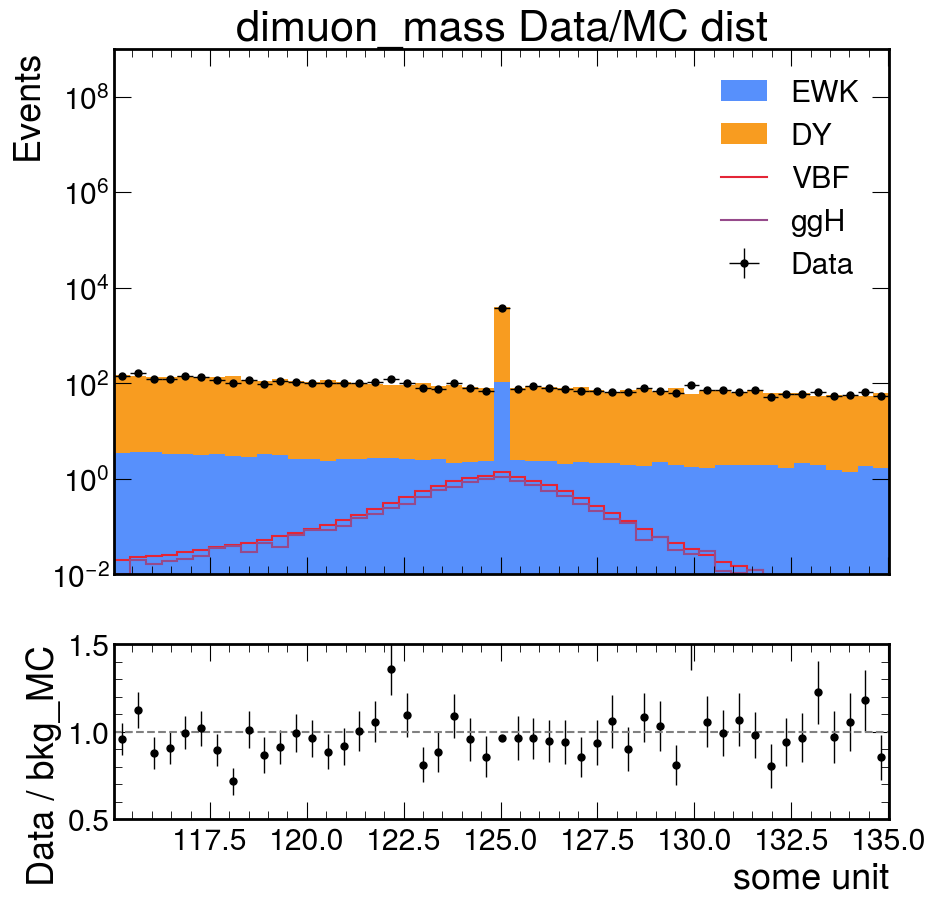

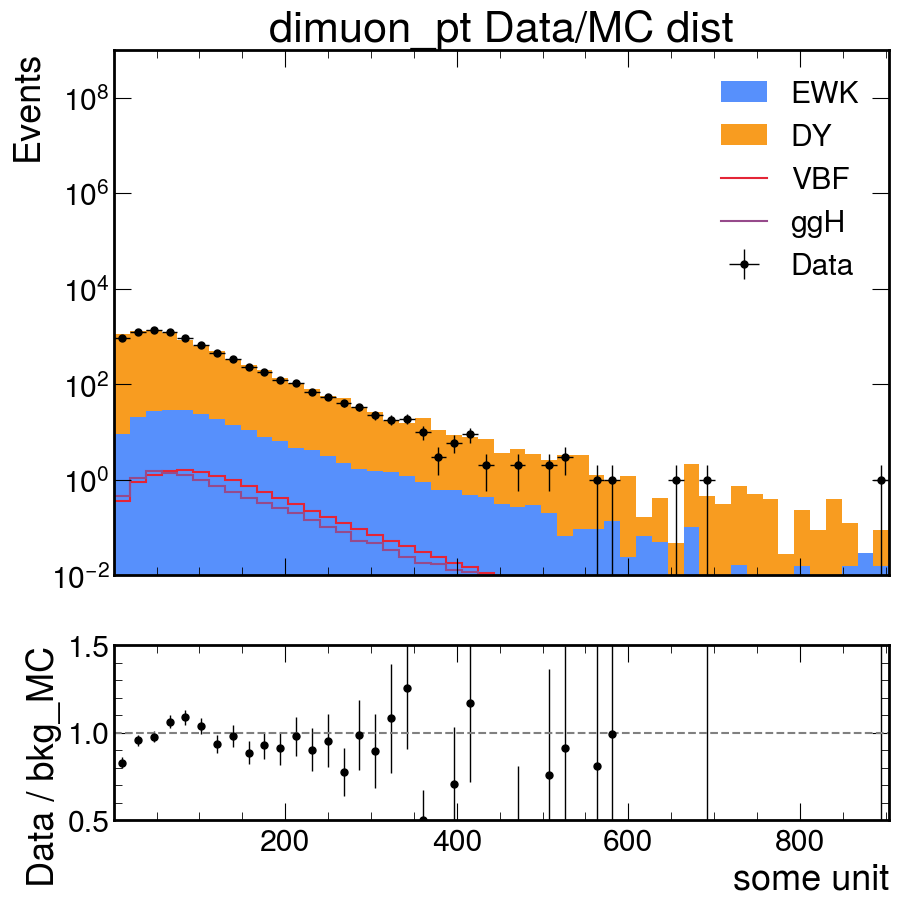

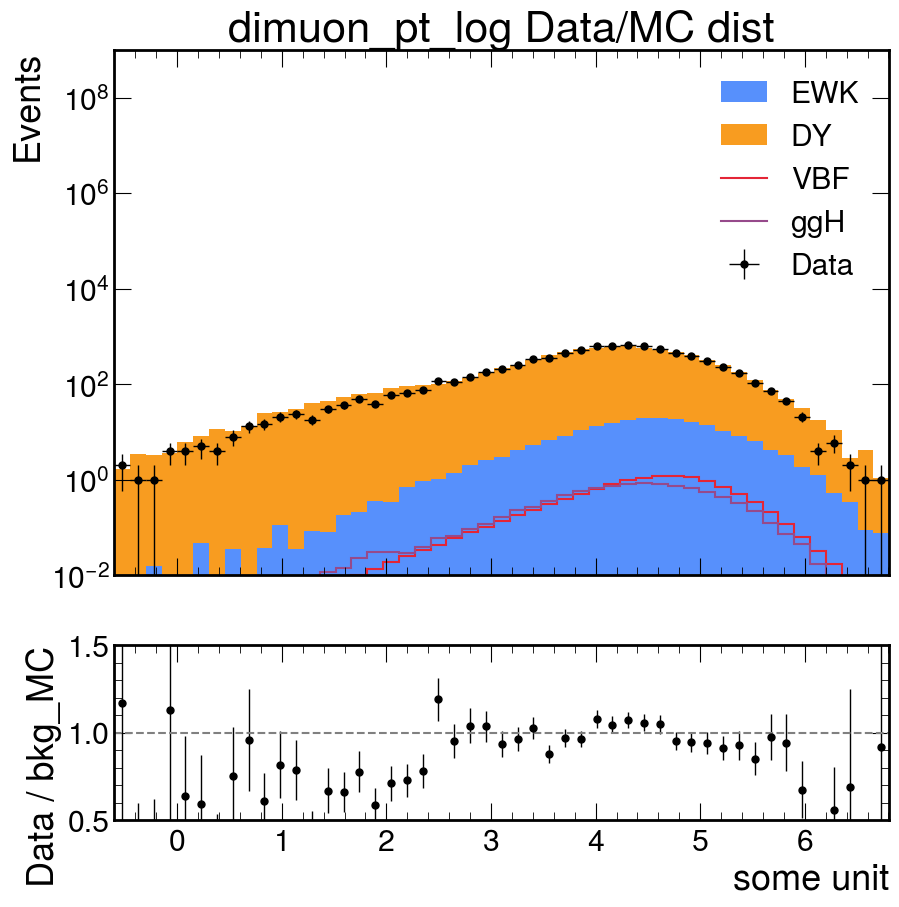

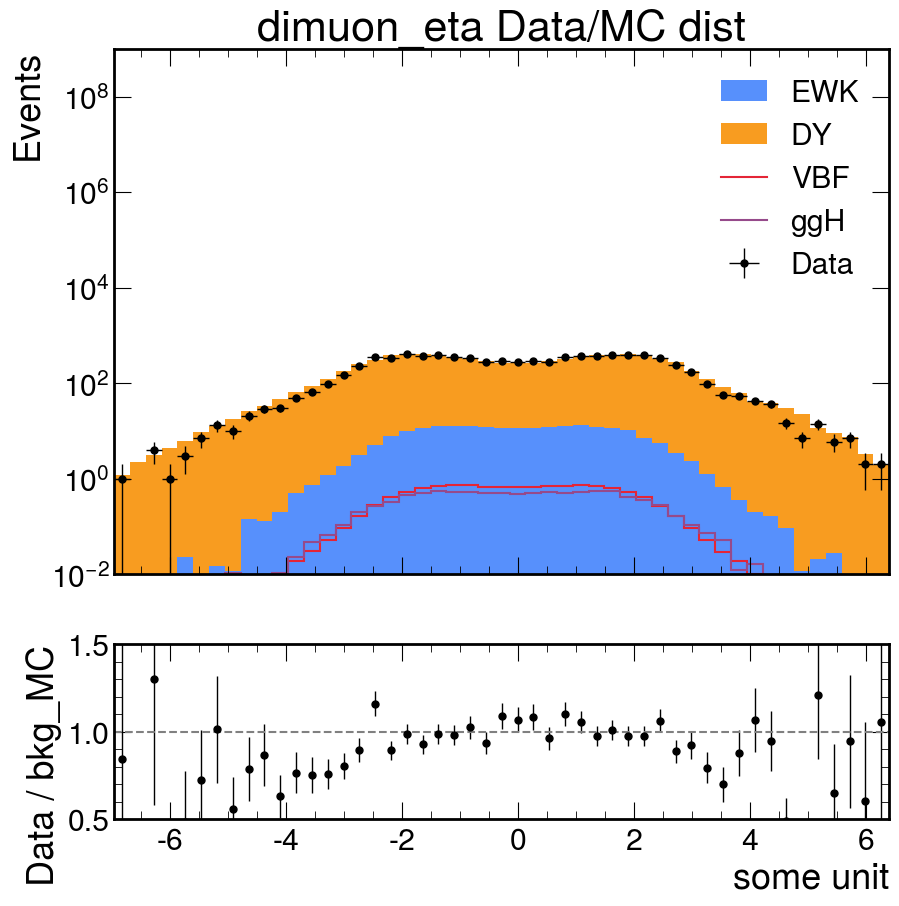

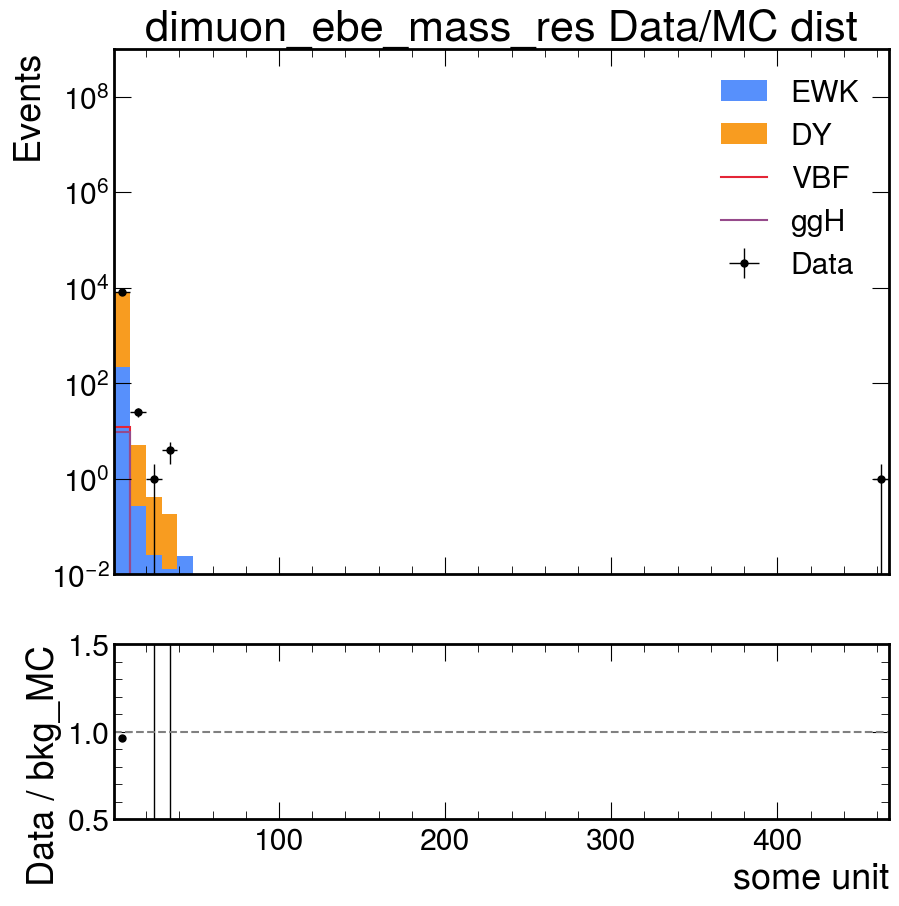

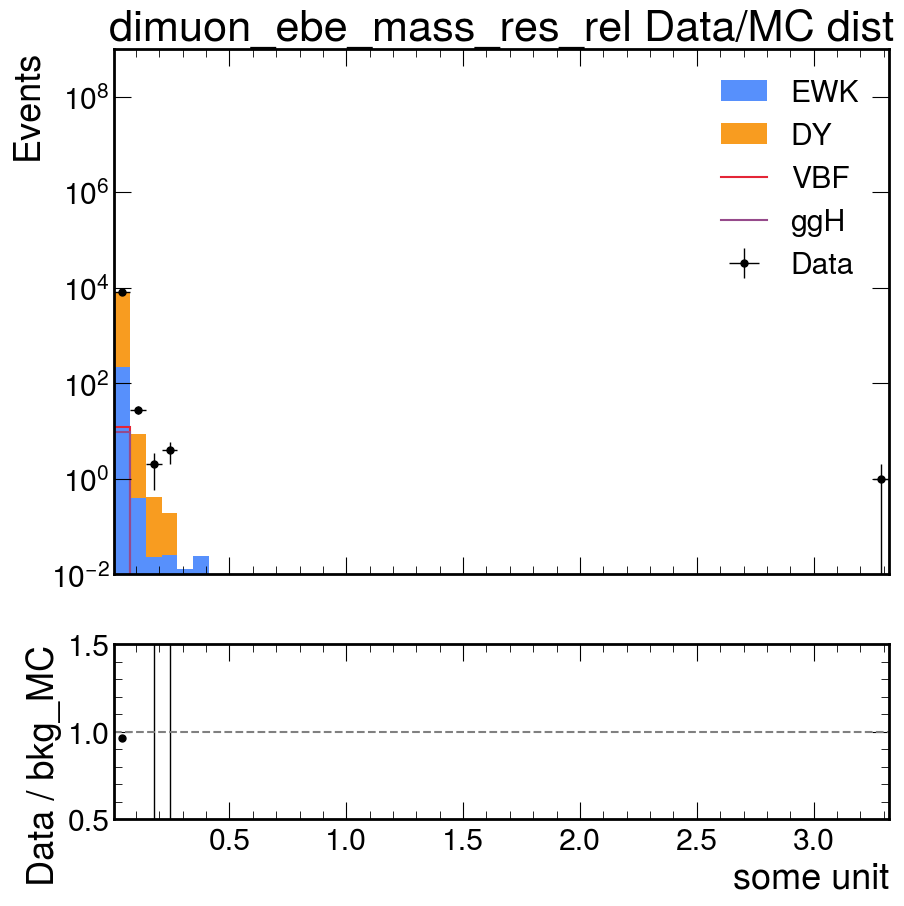

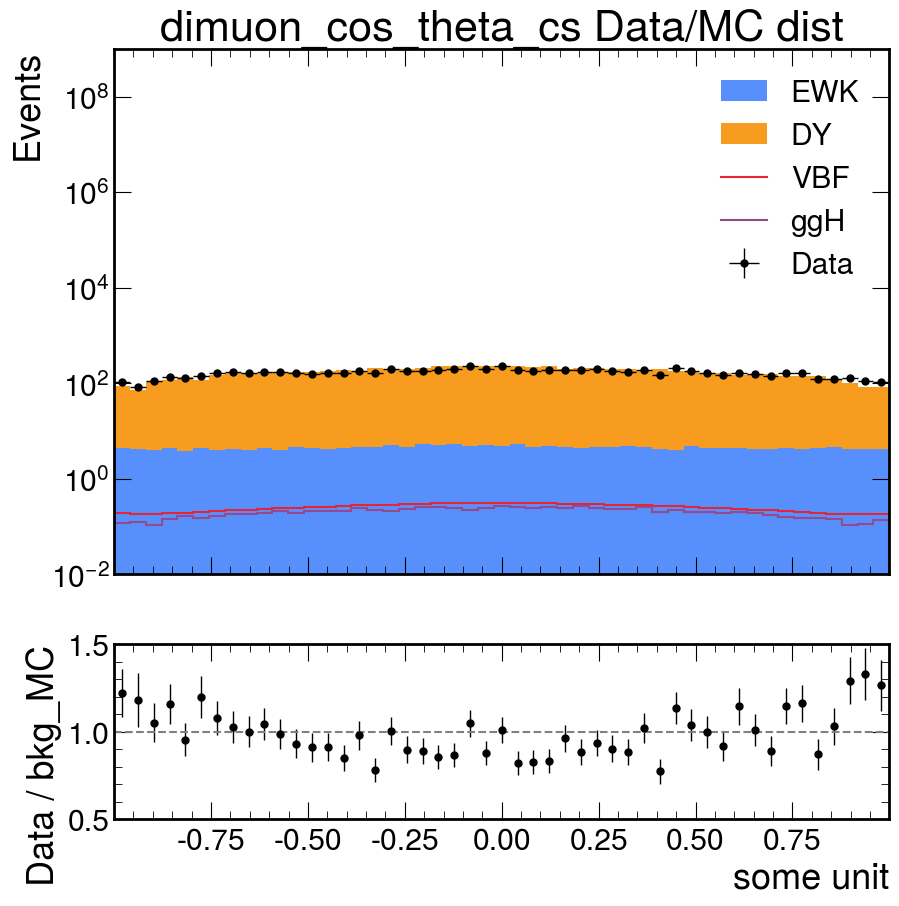

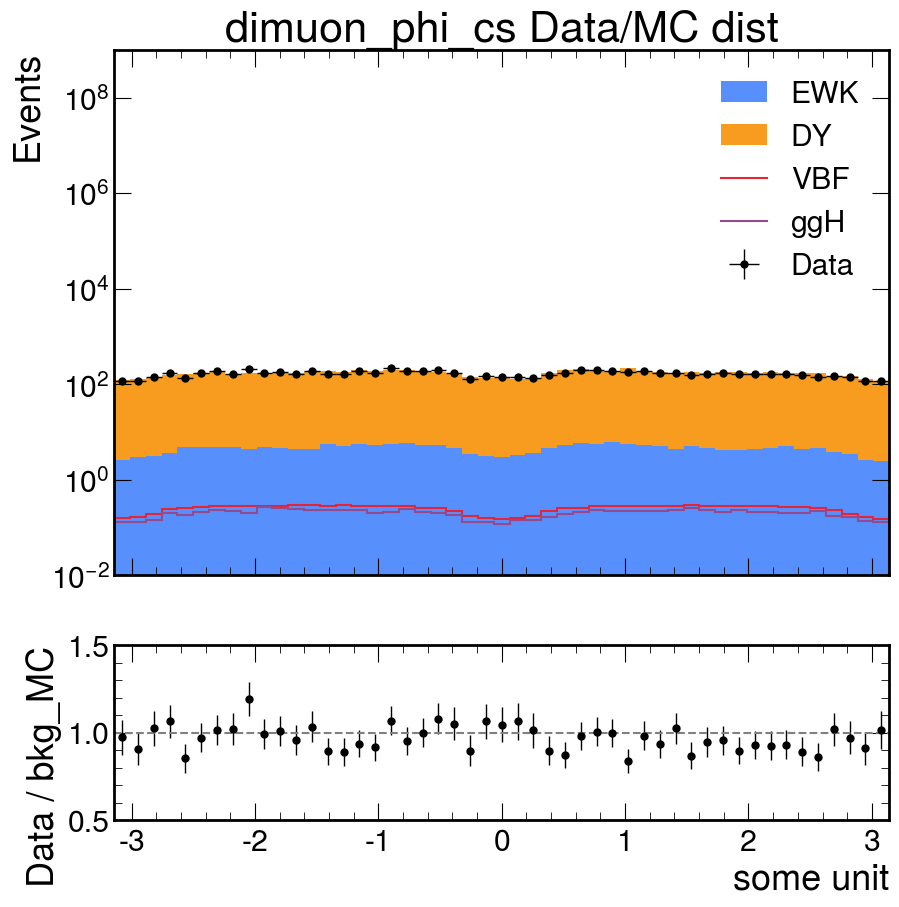

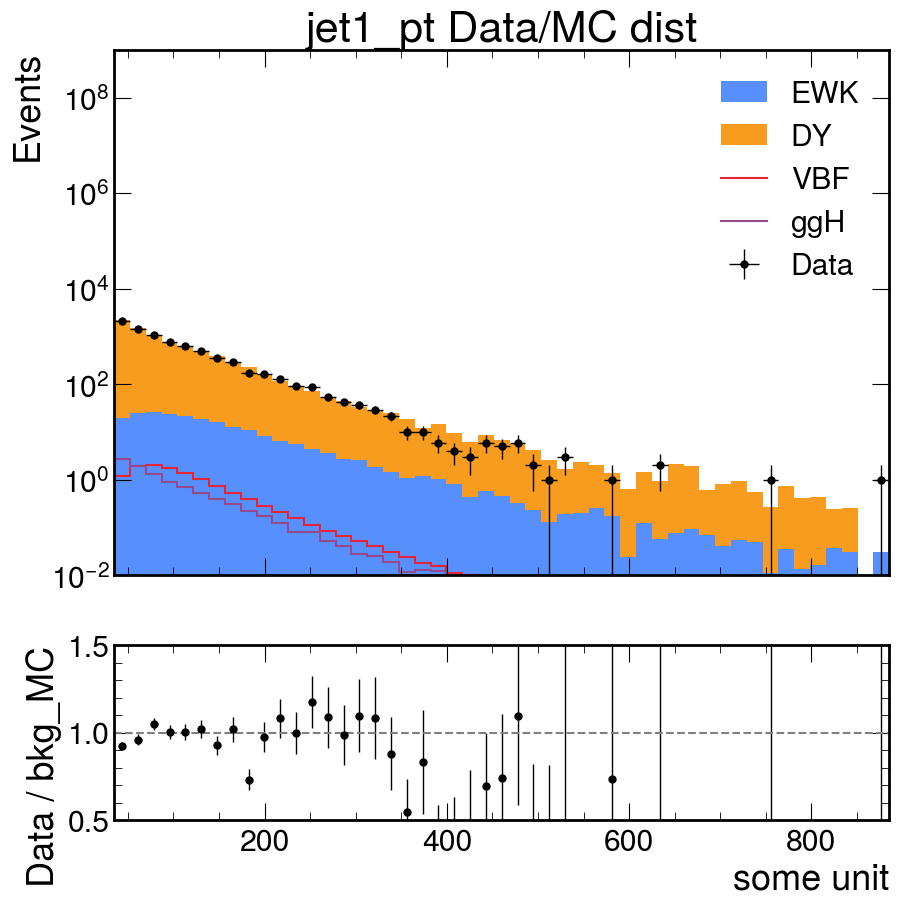

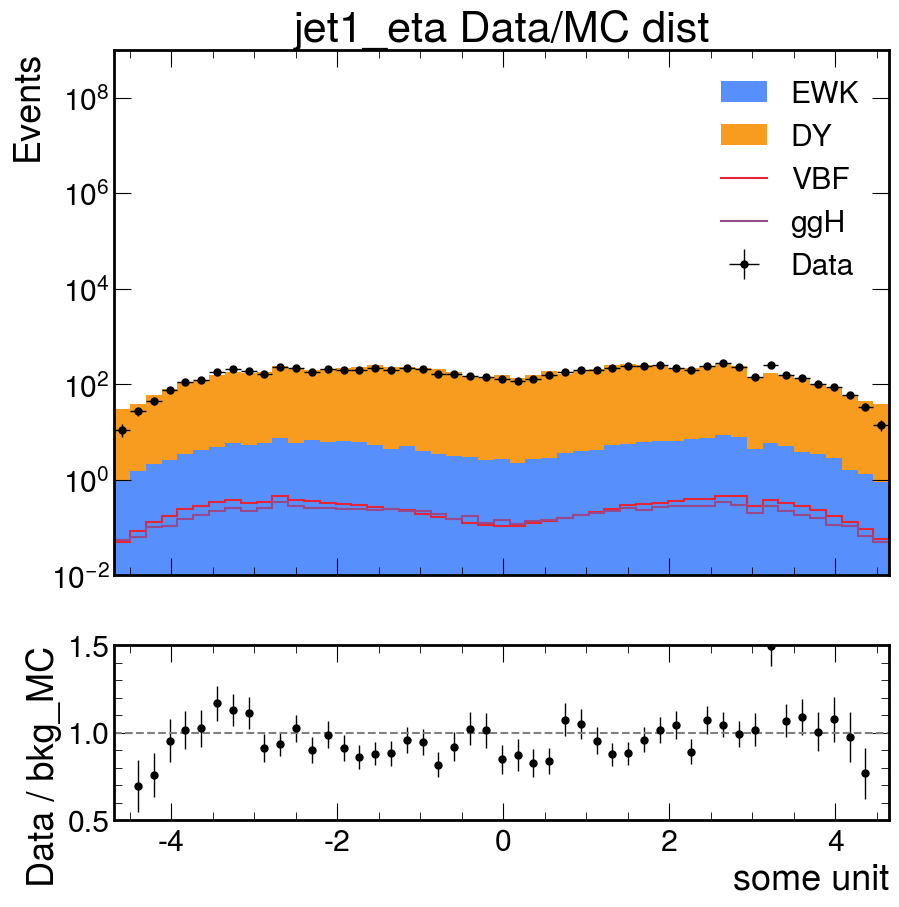

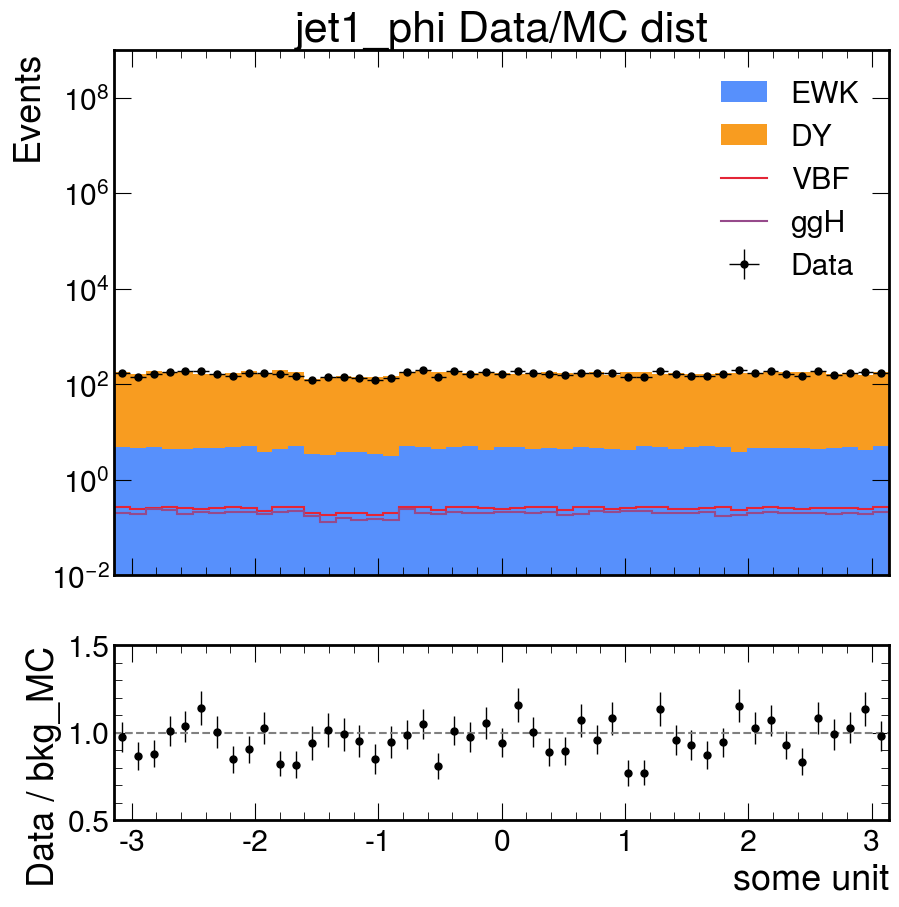

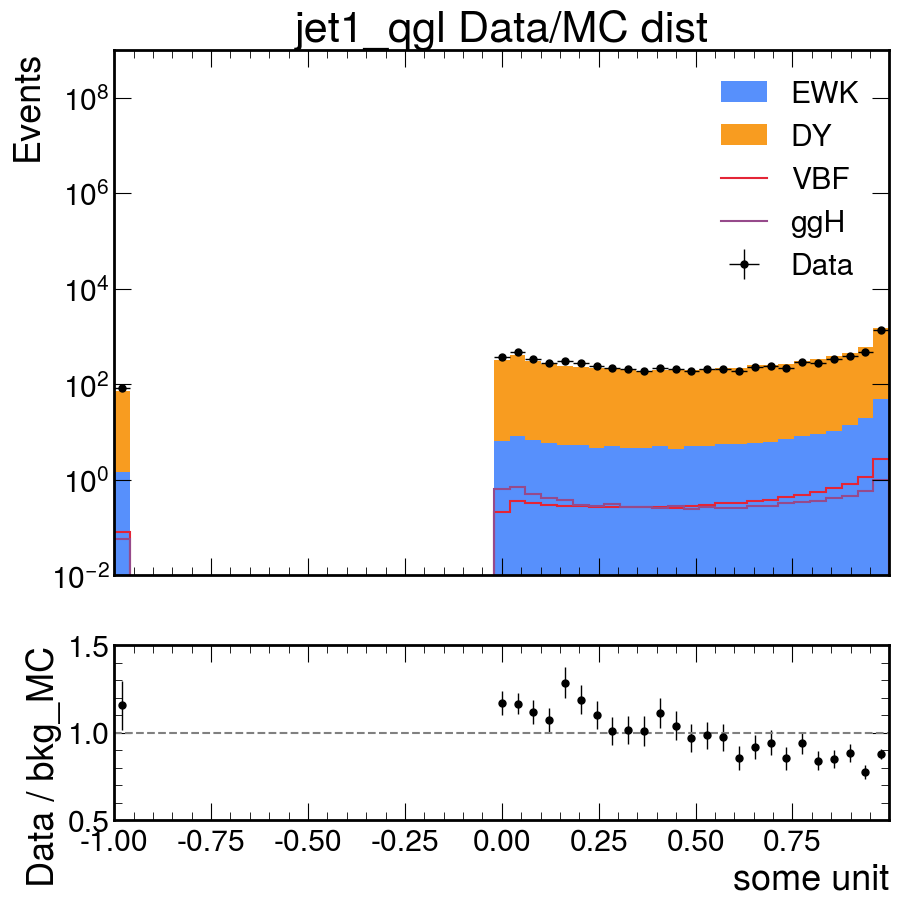

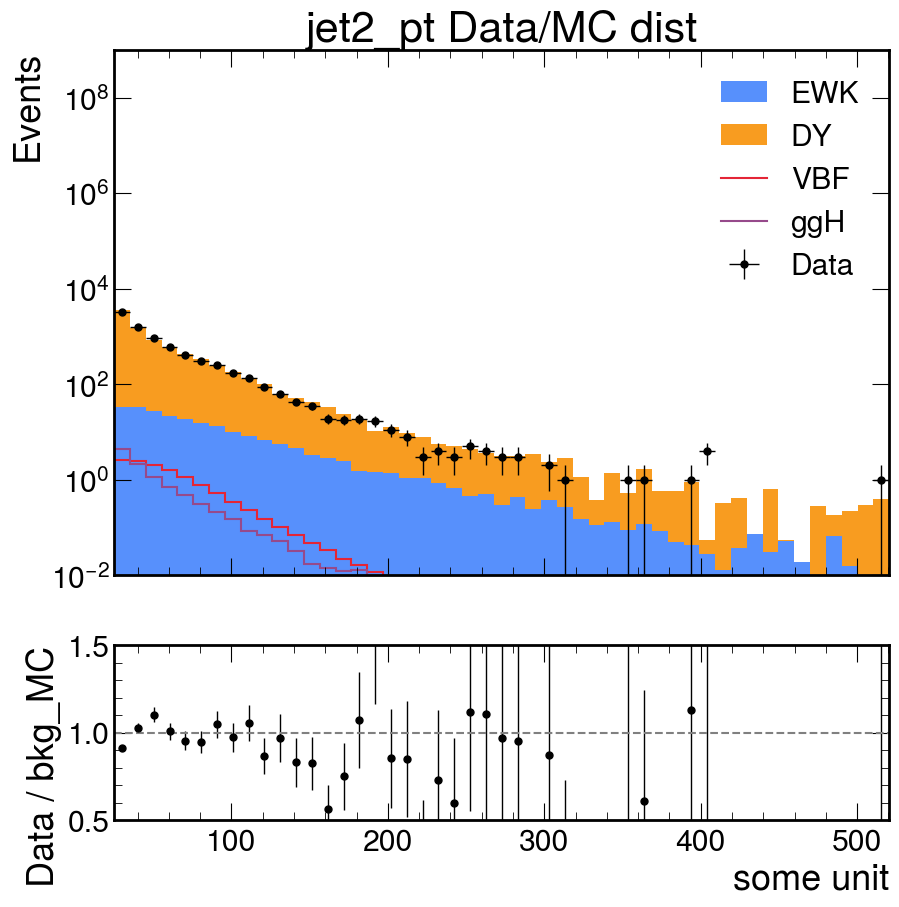

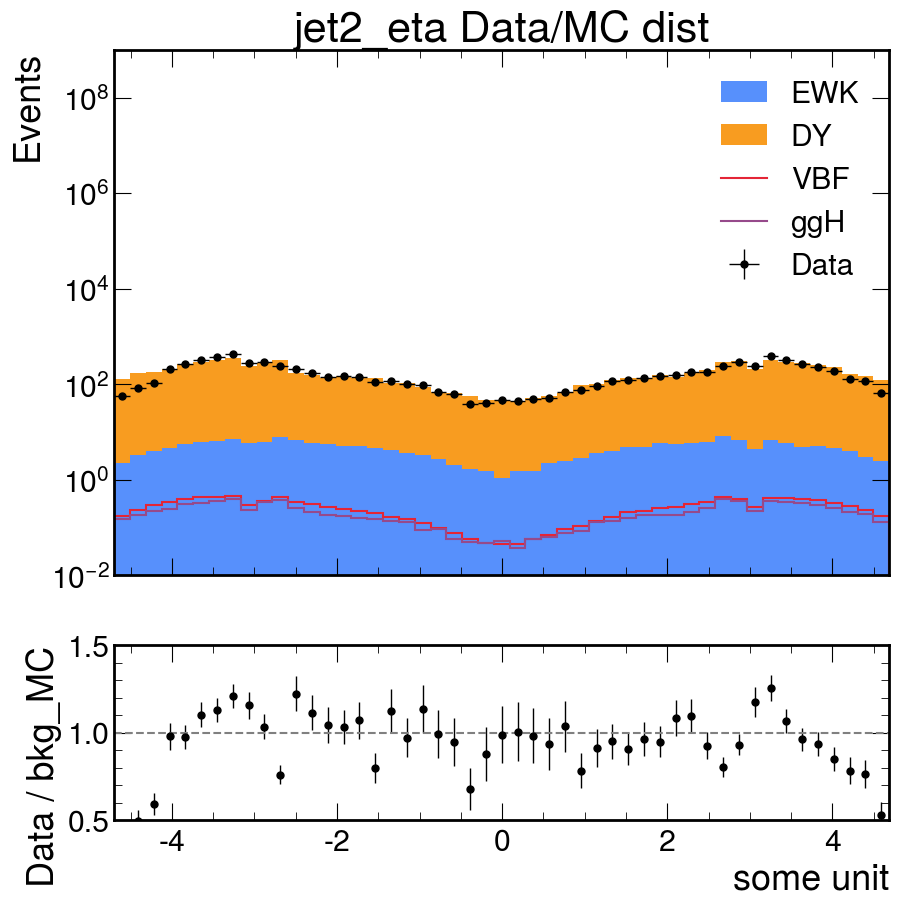

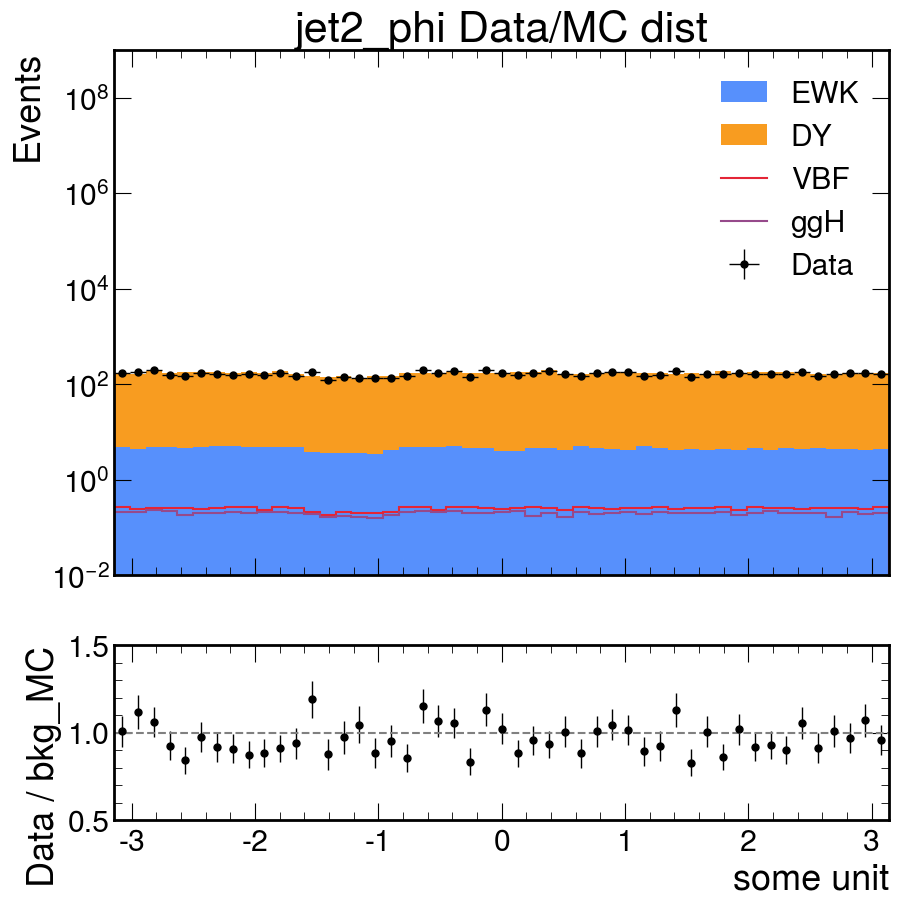

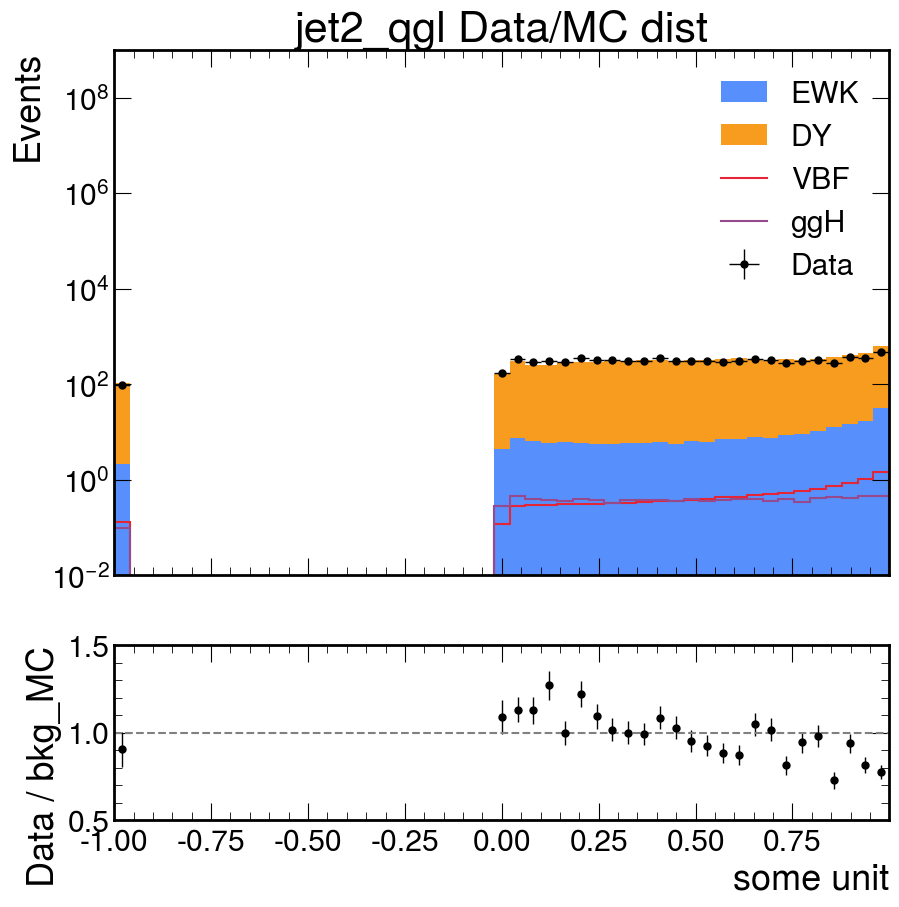

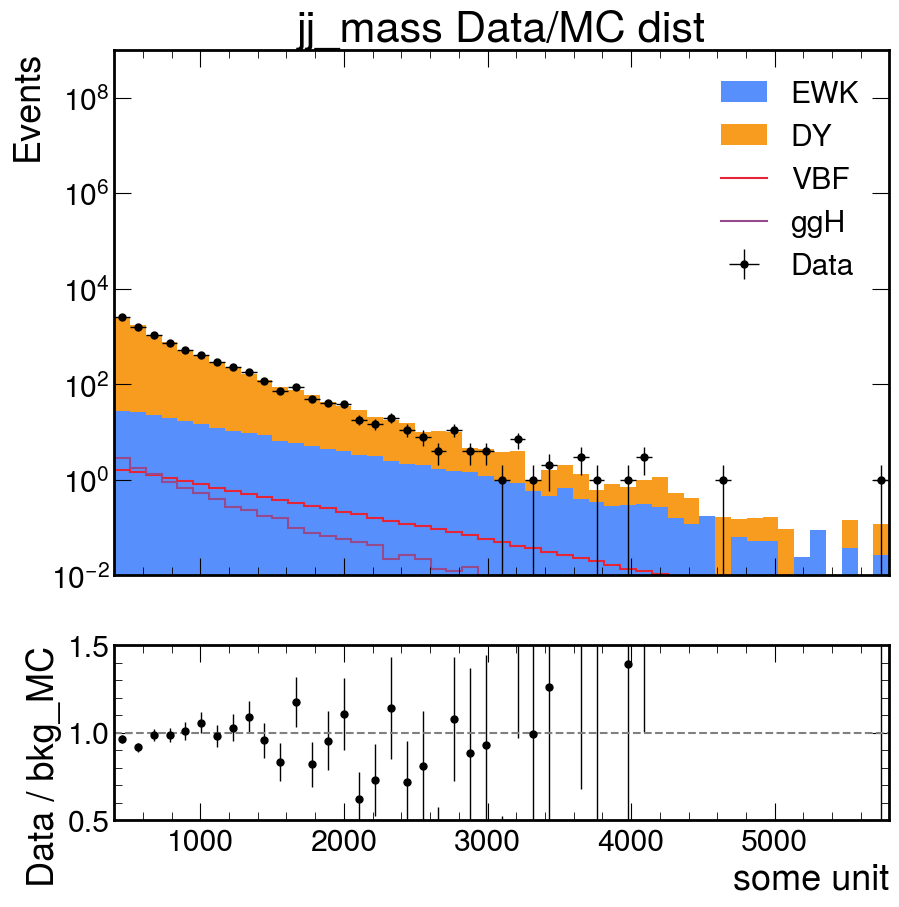

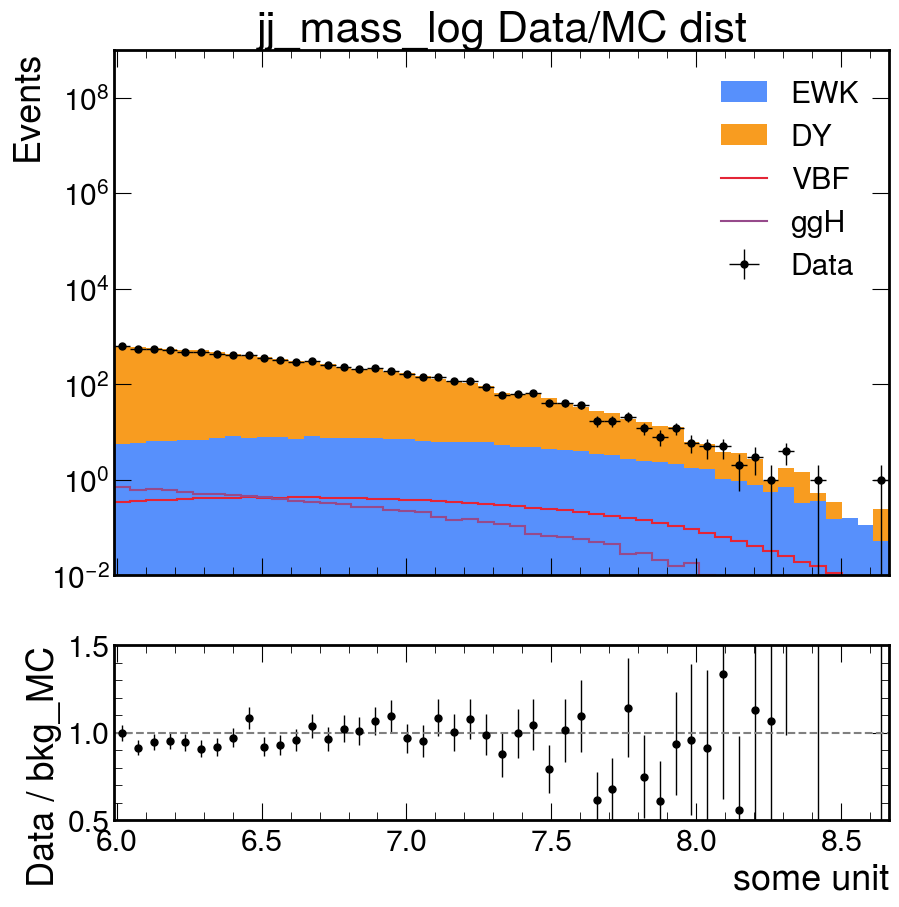

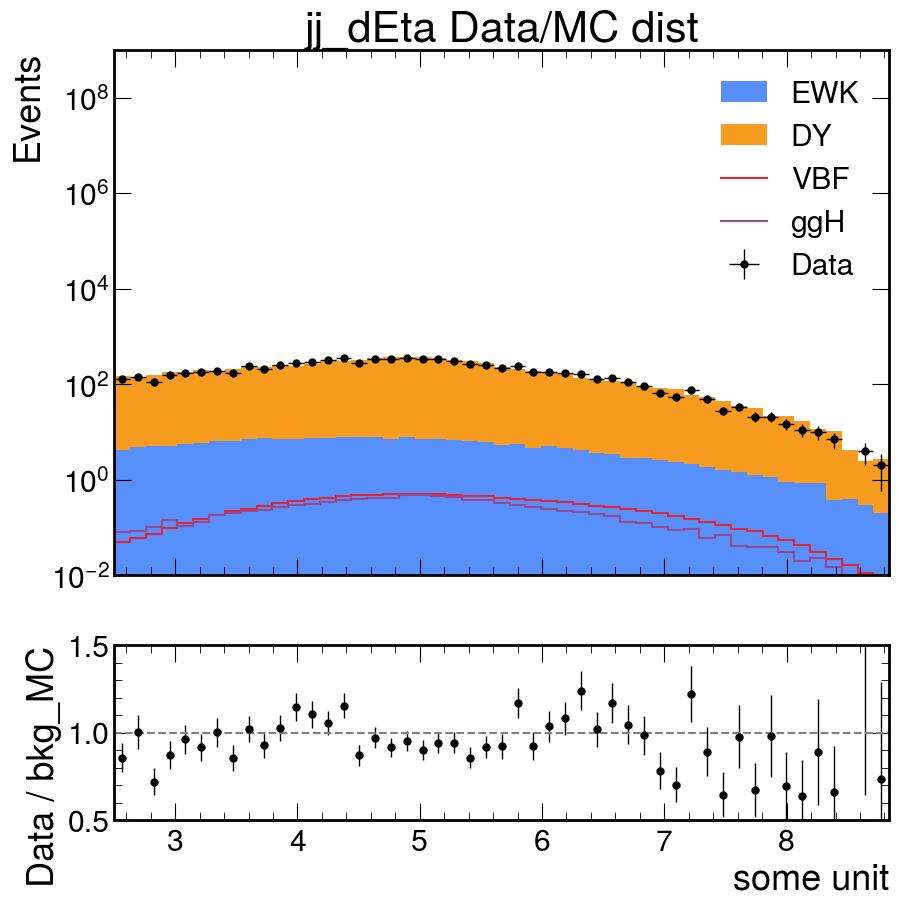

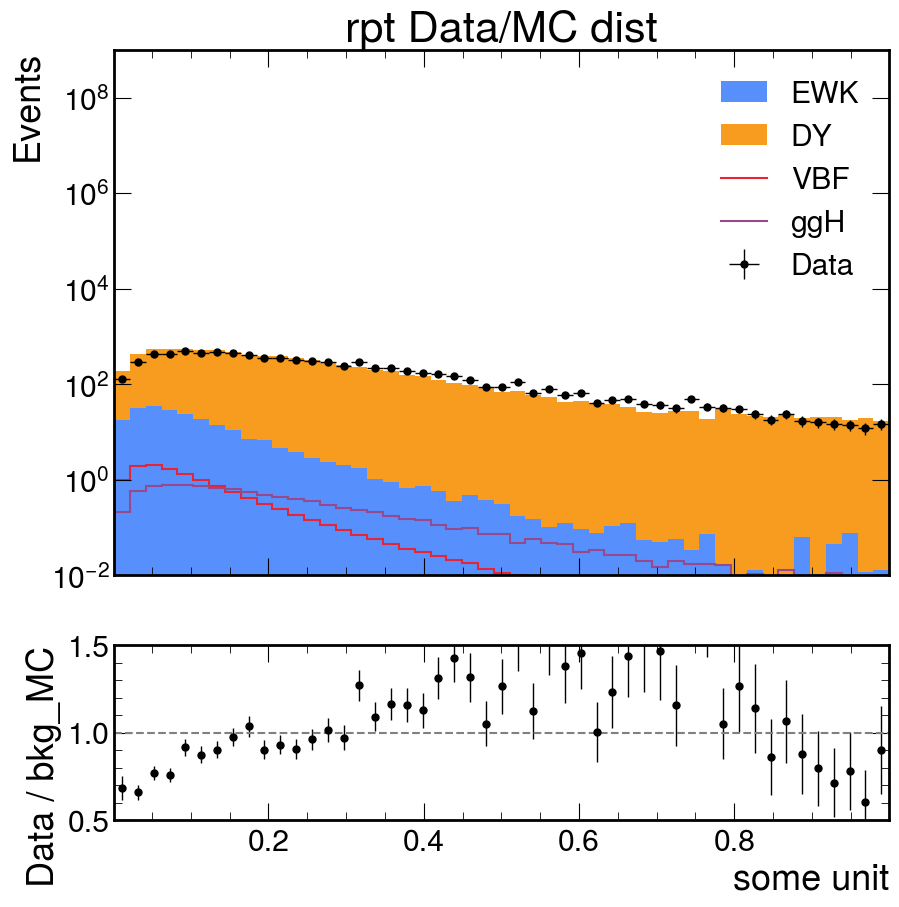

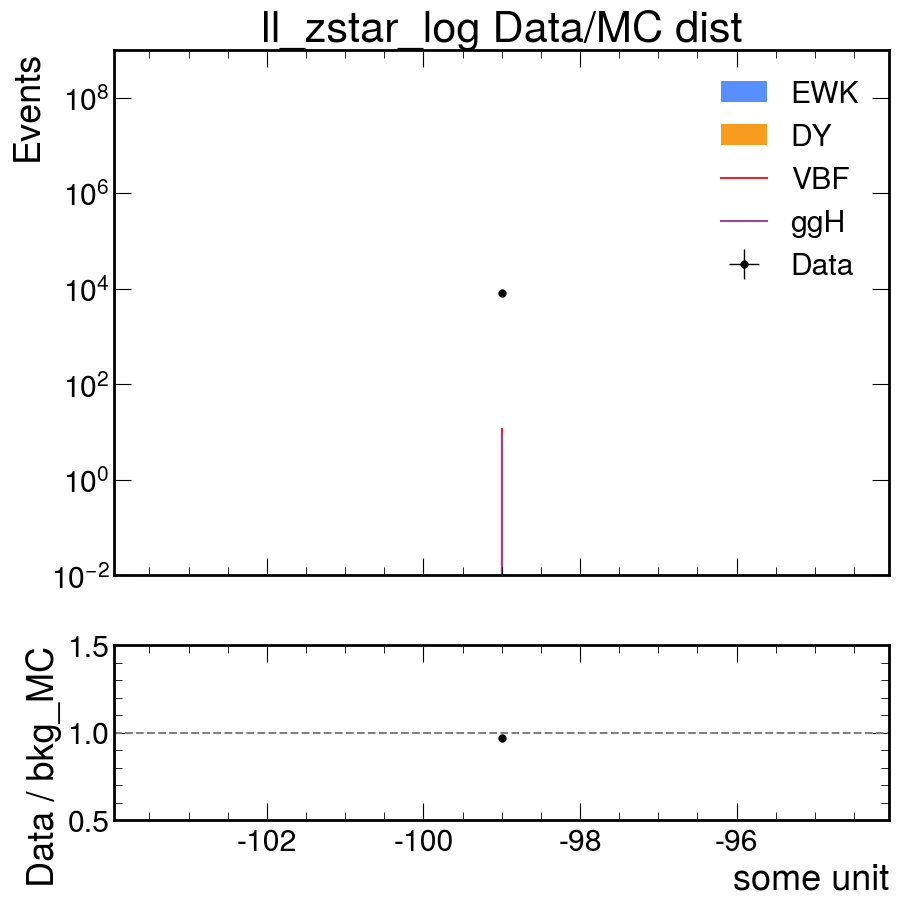

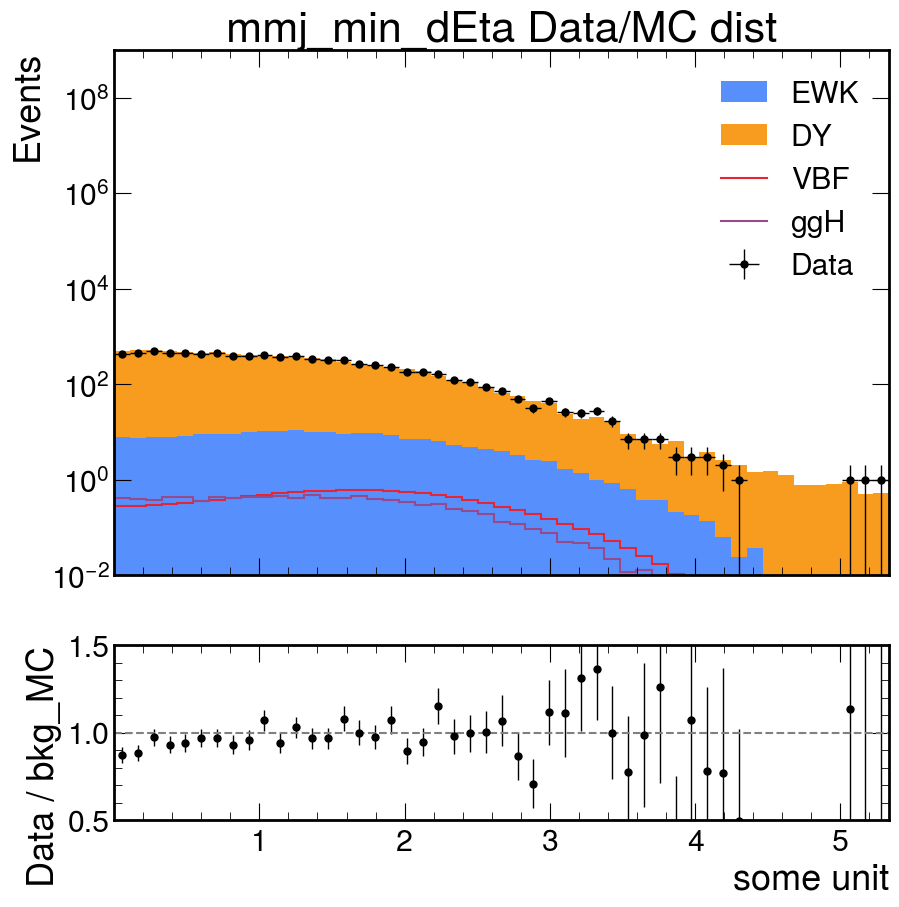

In [21]:
training_features = [
    "dimuon_mass",
    "dimuon_pt",
    "dimuon_pt_log",
    "dimuon_eta",
    "dimuon_ebe_mass_res",
    "dimuon_ebe_mass_res_rel",
    "dimuon_cos_theta_cs",
    "dimuon_phi_cs",
    "jet1_pt",
    "jet1_eta",
    "jet1_phi",
    "jet1_qgl",
    "jet2_pt",
    "jet2_eta",
    "jet2_phi",
    "jet2_qgl",
    "jj_mass",
    "jj_mass_log",
    "jj_dEta",
    "rpt",
    "ll_zstar_log",
    "mmj_min_dEta",
    "nsoftjets5",
    "htsoft2",
    # "year",
]

# -----------------------------------------
# plot data/MC for each training feature
# -----------------------------------------
load_path = "/work/users/yun79/stage2_output/test/vbf/2018"
data_events = ak.from_parquet(load_path+f"/processed_events_data.parquet")
dy_events = ak.from_parquet(load_path+f"/processed_events_bkgMC_dy.parquet")
ewk_events = ak.from_parquet(load_path+f"/processed_events_bkgMC_ewk.parquet")
vbf_events = ak.from_parquet(load_path+f"/processed_events_sigMC_vbf.parquet")
ggh_events = ak.from_parquet(load_path+f"/processed_events_sigMC_ggh.parquet")

print(data_events.fields)
for feature in training_features:
    print(f"feature: {feature}")
    data = {
        "values" :ak.to_numpy(data_events[feature]),
        "weights":ak.to_numpy(data_events.wgt_nominal_total )
    }
    bkg_MC_dict = {
        "EWK" :{
            "values" :ak.to_numpy(ewk_events[feature]),
            "weights":ak.to_numpy(ewk_events.wgt_nominal_total )
        },
        "DY" :{
            "values" :ak.to_numpy(dy_events[feature]),
            "weights":ak.to_numpy(dy_events.wgt_nominal_total )
        },     
    }
    sig_MC_dict = {
        "VBF" :{
            "values" :ak.to_numpy(vbf_events[feature]),
            "weights":ak.to_numpy(vbf_events.wgt_nominal_total )
        },
        "ggH" :{
            "values" :ak.to_numpy(ggh_events[feature]),
            "weights":ak.to_numpy(ggh_events.wgt_nominal_total )
        },     
    }
    max = ak.max(data_events[feature])
    min = ak.min(data_events[feature])
    binning = np.linspace(min, max, 50)
    save_full_path = f"./quick_plots/DNN_input/DNN_input_{feature}.pdf"
    plotDataMC_compare(
        binning, 
        data, 
        bkg_MC_dict, 
        save_full_path,
        sig_MC_dict=sig_MC_dict,
        title=feature + " Data/MC dist", 
        xtitle="some unit", 
    )

In [24]:
A = np.ones(3)
B = np.ones(3)
l = [A,B]
np.concatenate(l, axis=0).shape

(6,)